<a href="https://colab.research.google.com/github/minjaekim070/Bootcamp_Project/blob/main/CNN_project_5%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

전체 데이터셋의 다운로드가 오래 걸려서 bottle 폴더에 대한 내용을 우선적으로 정상/비정상으로 분류할 수 있도록 진행

#Library import


In [1]:
# 패키지 import
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf
from torchvision import transforms, datasets, utils
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing import image


#이미지 업로드 및 배열 변환


In [2]:
# 이미지 경로
train_data_dir = '/content/drive/MyDrive/bottle/train/good'
large_data_dir = '/content/drive/MyDrive/bottle/test/broken_large'
small_data_dir = '/content/drive/MyDrive/bottle/test/broken_small'
contamination_data_dir='/content/drive/MyDrive/bottle/test/contamination'
test_data_dir = '/content/drive/MyDrive/bottle/test/good'
gr_tr_large_dir = '/content/drive/MyDrive/bottle/ground_truth/broken_large'
gr_tr_small_dir = '/content/drive/MyDrive/bottle/ground_truth/broken_small'
gr_tr_contamination_dir = '/content/drive/MyDrive/bottle/ground_truth/contamination'

In [3]:
#이미지를 데이터로 변환
def load_image_data(image_dir):
    image_data = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = image.load_img(img_path, target_size=(64, 64))  # 이미지를 지정된 크기로 로드합니다
        img_array = image.img_to_array(img)  # 이미지를 배열 형태로 변환합니다
        image_data.append(img_array)
    return image_data

def load_data(data_dir, test_data_dir, large_data_dir, small_data_dir, contamination_data_dir):
    train_image_data = load_image_data(data_dir)
    test_image_data = load_image_data(test_data_dir)
    large_image_data = load_image_data(large_data_dir)
    small_image_data = load_image_data(small_data_dir)
    contamination_image_data = load_image_data(contamination_data_dir)
    return train_image_data, test_image_data, large_image_data, small_image_data, contamination_image_data

train_image_data, test_image_data, large_image_data, small_image_data, contamination_image_data = load_data(train_data_dir, test_data_dir, large_data_dir, small_data_dir, contamination_data_dir)


In [4]:
#Segmentation용 이미지를 데이터로 변환
def load_data(gr_tr_large_dir, gr_tr_small_dir, gr_tr_contamination_dir):
    gr_tr_large_data = load_image_data(gr_tr_large_dir)
    gr_tr_small_data = load_image_data(gr_tr_small_dir)
    gr_tr_contamination_data = load_image_data(gr_tr_contamination_dir)
    return gr_tr_large_data, gr_tr_small_data, gr_tr_contamination_data

gr_tr_large_data, gr_tr_small_data, gr_tr_contamination_data = load_data(gr_tr_large_dir, gr_tr_small_dir, gr_tr_contamination_dir)


In [5]:
#배열로 변환, normalization
def preprocess_image_data(image_data):
    return np.array(image_data) / 255

train_image_data = preprocess_image_data(train_image_data)
test_image_data = preprocess_image_data(test_image_data)
small_image_data = preprocess_image_data(small_image_data)
large_image_data = preprocess_image_data(large_image_data)
contamination_image_data = preprocess_image_data(contamination_image_data)
gr_tr_large_data = preprocess_image_data(gr_tr_large_data)
gr_tr_small_data = preprocess_image_data(gr_tr_small_data)
gr_tr_contamination_data = preprocess_image_data(gr_tr_contamination_data)


In [6]:
#데이터 확인
test_image_data[0][16][16]

array([0.40392157, 0.34117648, 0.32156864], dtype=float32)

#데이터 전처리

크게 파손, 적게 파손, 오염된 데이터 셋 모두 augmentation을 통해 데이터의 양을 늘린 뒤에, train과 test로 분리 후에 예측 결과 확인

In [7]:
#배열 변환된 데이터 셋
"""
train_image_data : 정상 훈련 데이터 (200)
test_image_data : 정상 테스트 데이터 (20)
small_image_data : 적게 파손 (20)
large_image_data : 크게 파손 (20)
contamination_image_data : 오염 (20)
"""

'\ntrain_image_data : 정상 훈련 데이터 (200)\ntest_image_data : 정상 테스트 데이터 (20)\nsmall_image_data : 적게 파손 (20)\nlarge_image_data : 크게 파손 (20)\ncontamination_image_data : 오염 (20)\n'

In [8]:
#정상 데이터셋이 너무 과도하게 많기 때문에 50개 정도로 추출
subset_train_data = train_image_data[:50]

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# 이미지 데이터 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,  # 이미지 회전 범위 (0~20도 사이에서 무작위로 회전)
    width_shift_range=0.1,  # 가로로 이미지 이동 범위 (전체 너비의 0.1 비율로 무작위로 이동)
    height_shift_range=0.1,  # 세로로 이미지 이동 범위 (전체 높이의 0.1 비율로 무작위로 이동)
    shear_range=0.2,  # 이미지 변형을 위한 전단 강도 (0.2 비율 내외로 무작위로 전단)
    zoom_range=0.2,  # 이미지 확대/축소 범위 (0.2 비율 내외로 무작위로 확대/축소)
    horizontal_flip=True,  # 이미지 수평 뒤집기
    fill_mode='nearest'  # 이미지 변형 시 채울 픽셀 값 설정
)

# augmented 이미지 개수
desired_num_augmented_images = 10

In [10]:
def augment_images(image_data, desired_num_augmented_images):
    augmented_images = []
    num_generated_images = 0

    while num_generated_images < desired_num_augmented_images:
        image = image_data[0]
        generated_images = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)

        augmented_images.extend(generated_images[0])
        num_generated_images = len(augmented_images)

    augmented_images = np.array(augmented_images[:desired_num_augmented_images])
    return augmented_images

# broken_small 이미지 증강
augmented_small_images = augment_images(small_image_data, desired_num_augmented_images)

# broken_large 이미지 증강
augmented_large_images = augment_images(large_image_data, desired_num_augmented_images)

# contamination 이미지 증강
augmented_contamination_images = augment_images(contamination_image_data, desired_num_augmented_images)


In [11]:
#데이터 개수 확인
print(test_image_data.shape[0])
print(small_image_data.shape[0])
print(large_image_data.shape[0])
print(contamination_image_data.shape[0])
print(augmented_small_images.shape[0])
print(augmented_large_images.shape[0])
print(augmented_contamination_images.shape[0])

20
22
20
21
10
10
10


In [12]:
#각각의 데이터와 augmented_image합친 후 shuffle
combined_small_data = np.concatenate((small_image_data, augmented_small_images), axis=0)
np.random.shuffle(combined_small_data)

combined_large_data = np.concatenate((large_image_data, augmented_large_images), axis=0)
np.random.shuffle(combined_large_data)

combined_contamination_data = np.concatenate((contamination_image_data, augmented_contamination_images), axis=0)
np.random.shuffle(combined_contamination_data)

#적게 파손, 크게 파손 모두 파손된 데이터로 합쳐서 분류
combined_broken_data = np.concatenate((combined_small_data, combined_large_data), axis=0)

In [13]:
#배열 변환된 데이터 셋
"""
subset_train_data : 정상 훈련 데이터
test_image_data : 정상 테스트 데이터
combined_broken_data : augmentation 진행한 broken_small, broken_large data
combined_contamination_data : augmentation 진행한 contamination_data
"""

'\nsubset_train_data : 정상 훈련 데이터\ntest_image_data : 정상 테스트 데이터\ncombined_broken_data : augmentation 진행한 broken_small, broken_large data\ncombined_contamination_data : augmentation 진행한 contamination_data\n'

In [14]:
#Train set 구성

# 데이터 개수 구하기
broken_num_samples = combined_broken_data.shape[0]
contamination_num_samples = combined_contamination_data.shape[0]

# 90%의 데이터 개수 계산
b_90 = int(0.90 * broken_num_samples)
c_90 = int(0.90 * contamination_num_samples)

# 90% 데이터 추출
b_new_data = combined_broken_data[:b_90]
c_new_data = combined_contamination_data[:c_90]

# subset_train_data와 combined_small_data 합치기
resized_images = np.concatenate((subset_train_data, b_new_data, c_new_data), axis=0)

In [15]:
all_labels = []
for i in range(0,subset_train_data.shape[0]):
  all_labels.append([1,0,0])
for j in range(0,b_new_data.shape[0]):
  all_labels.append([0,1,0])
for k in range(0,c_new_data.shape[0]):
  all_labels.append([0,0,1])
all_labels = np.array(all_labels)

In [16]:
#Test set 구성
b_test_data = combined_broken_data[b_90:]
c_test_data = combined_contamination_data[c_90:]
test_set_data = np.concatenate((test_image_data, b_test_data, c_test_data),axis=0)

test_labels = []
for i in range(0,test_image_data.shape[0]):
  test_labels.append([1,0,0])
for j in range(0,b_test_data.shape[0]):
  test_labels.append([0,1,0])
for k in range(0,c_test_data.shape[0]):
  test_labels.append([0,0,1])
test_labels = np.array(test_labels)

In [17]:
#최종 데이터셋 shape 확인
print(resized_images.shape)
print(all_labels.shape)
print(test_set_data.shape)
print(test_labels.shape)

(132, 64, 64, 3)
(132, 3)
(31, 64, 64, 3)
(31, 3)


#모델 구성 및 결과 예측

In [21]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers,Sequential


# CNN 모델을 함수 형태로 정의
def create_model():
    model = Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# KerasClassifier를 사용하여 Keras 모델을 래핑
keras_model = KerasClassifier(build_fn=create_model)

# 그리드 탐색을 위한 hyperparameter 조합 설정
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# GridSearchCV를 사용하여 그리드 탐색 수행
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)
grid_search_result = grid_search.fit(resized_images, all_labels)

# 최적의 hyperparameter 조합과 결과 출력
print("Best Score: ", grid_search_result.best_score_)
print("Best Params: ", grid_search_result.best_params_)

Epoch 1/10


<ipython-input-21-e52defb22343>:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=create_model)


3/3 [==============================] - 3s 18ms/step - loss: 1.0269 - accuracy: 0.4545
Epoch 2/10
3/3 [==============================] - 0s 21ms/step - loss: 0.8238 - accuracy: 0.6250
Epoch 3/10
3/3 [==============================] - 0s 19ms/step - loss: 0.8654 - accuracy: 0.6250
Epoch 4/10
3/3 [==============================] - 0s 24ms/step - loss: 0.8325 - accuracy: 0.6250
Epoch 5/10
3/3 [==============================] - 0s 23ms/step - loss: 0.8233 - accuracy: 0.6250
Epoch 6/10
3/3 [==============================] - 0s 21ms/step - loss: 0.8209 - accuracy: 0.6250
Epoch 7/10
3/3 [==============================] - 0s 39ms/step - loss: 0.8207 - accuracy: 0.6250
Epoch 8/10
3/3 [==============================] - 0s 19ms/step - loss: 0.7876 - accuracy: 0.6250
Epoch 9/10
3/3 [==============================] - 0s 23ms/step - loss: 0.7957 - accuracy: 0.6250
Epoch 10/10
2/2 [==============================] - 0s 10ms/step - loss: 2.8180 - accuracy: 0.0000e+00
Epoch 1/10
3/3 [====================

Grid Search 결과 Best Params:  {'batch_size': 32, 'epochs': 20} 으로 결과가 나왔기 때문에, 해당 hyperparameter로 학습 진행

In [23]:
model = create_model()

#모델 학습
model.fit(resized_images, all_labels, epochs=20, batch_size=32, verbose=1)

model.save('mnist_cnn,h5')

Epoch 1/20
5/5 [==============================] - 4s 15ms/step - loss: 1.0902 - accuracy: 0.3333
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 1.0599 - accuracy: 0.4167
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 1.0521 - accuracy: 0.4167
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 1.0129 - accuracy: 0.4167
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.9406 - accuracy: 0.5758
Epoch 6/20
5/5 [==============================] - 0s 11ms/step - loss: 0.8849 - accuracy: 0.6061
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.6858 - accuracy: 0.7424
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.7082 - accuracy: 0.7121
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.7057 - accuracy: 0.8258
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.4866 - accuracy: 0.7879
Epoch 11/20
5/5 [============

In [24]:
# test set에 대한 예측 수행
predictions = model.predict(test_set_data)

# 최종 예측 레이블 생성
predicted_labels = []
for prediction in predictions:
    if prediction[0] > prediction[1] and prediction[0] > prediction[2]:
        predicted_labels.append([1, 0, 0])
    elif prediction[1] > prediction[0] and prediction[1] > prediction[2]:
        predicted_labels.append([0, 1, 0])
    else:
        predicted_labels.append([0, 0, 1])
predicted_labels = np.array(predicted_labels)

#예측률 확인
count = 0
for i in range(0,predicted_labels.shape[0]):
  if np.array_equal(predicted_labels[i], test_labels[i]):
        count += 1

prediction_accuracy = count / predicted_labels.shape[0] * 100
print('test set에 대한 예측률: {}%'.format(prediction_accuracy))


1/1 [==============================] - 0s 288ms/step
test set에 대한 예측률: 83.87096774193549%


In [25]:
#원본 데이터에 대한 예측 및 평가 함수
def predict_and_evaluate(model, data, target_labels):
    predictions = model.predict(data)

    predicted_labels = []
    for prediction in predictions:
        if prediction[0] > prediction[1] and prediction[0] > prediction[2]:
            predicted_labels.append([1, 0, 0])
        elif prediction[1] > prediction[0] and prediction[1] > prediction[2]:
            predicted_labels.append([0, 1, 0])
        else:
            predicted_labels.append([0, 0, 1])
    predicted_labels = np.array(predicted_labels)

    count = 0
    for i in range(predicted_labels.shape[0]):
        if np.array_equal(predicted_labels[i], target_labels):
            count += 1

    prediction_accuracy = count / predicted_labels.shape[0] * 100
    return prediction_accuracy

In [26]:
#원본 데이터에 대한 예측 및 정확도 평가

# broken_large
accuracy_large = predict_and_evaluate(model, large_image_data, [0, 1, 0])
print('broken_large에 대한 예측률: {}%'.format(accuracy_large))

# broken_small
accuracy_small = predict_and_evaluate(model, small_image_data, [0, 1, 0])
print('broken_small에 대한 예측률: {}%'.format(accuracy_small))

#contamination
accuracy_contamination = predict_and_evaluate(model, contamination_image_data, [0,0,1])
print('contamination에 대한 예측률:{}%'.format(accuracy_contamination))

1/1 [==============================] - 0s 175ms/step
broken_large에 대한 예측률: 95.0%
1/1 [==============================] - 0s 138ms/step
broken_small에 대한 예측률: 95.45454545454545%
1/1 [==============================] - 0s 127ms/step
contamination에 대한 예측률:71.42857142857143%


#Image Segmentation


In [27]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [28]:
# U-Net model
# coded by st.watermelon
#https://pasus.tistory.com/204 링크
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate


In [ ]:
#배열 변환된 ground_truth 이미지
"""
gr_tr_large_data : ground_truth 데이터 (20)
gr_tr_small_data : ground_truth 데이터 (22)
gr_tr_contamination_data : ground_truth 데이터 (21)
large_image_data : 크게 파손 (20)
small_image_data : 적게 파손 (22)
contamination_image_data : 오염 (21)
"""

In [31]:
#train, test set 분리
gr_tr_large_80,gr_tr_small_80, gr_tr_conta_80  = 16, 17, 17
gr_tr_train_set = np.concatenate((gr_tr_large_data[:gr_tr_large_80], gr_tr_small_data[:gr_tr_small_80], gr_tr_contamination_data[:gr_tr_conta_80]),axis=0)
gr_tr_test_set = np.concatenate((gr_tr_large_data[gr_tr_large_80:], gr_tr_small_data[gr_tr_small_80:], gr_tr_contamination_data[gr_tr_conta_80:]),axis=0)
train_image_set = np.concatenate((large_image_data[:gr_tr_large_80], small_image_data[:gr_tr_small_80], contamination_image_data[:gr_tr_conta_80]),axis=0)
test_image_set = np.concatenate((large_image_data[gr_tr_large_80:], small_image_data[gr_tr_small_80:], contamination_image_data[gr_tr_conta_80:]),axis=0)

In [32]:
print(gr_tr_train_set.shape, gr_tr_test_set.shape, train_image_set.shape, test_image_set.shape)

(50, 64, 64, 3) (13, 64, 64, 3) (50, 64, 64, 3) (13, 64, 64, 3)


In [ ]:
#Train, Test set
"""
gr_tr_train_set, train_image_set : train (50)
gr_tr_test_set, test_image_set : test (13)
"""

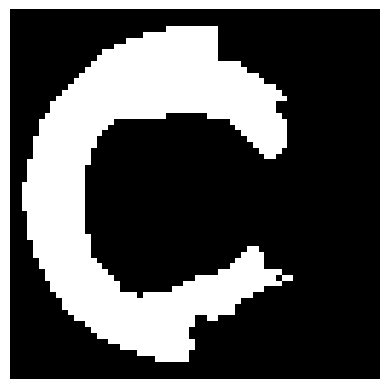

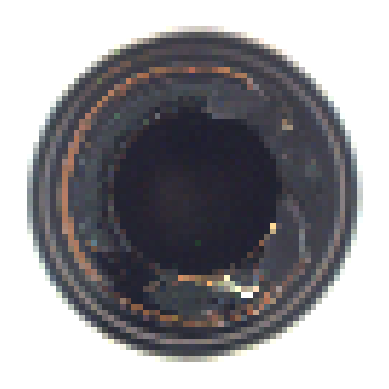

In [34]:
#이미지, ground_truth 확인
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
# gr_tr_large_data와 large_image_data 이미지 동시 plot
plot_image(gr_tr_large_data[0])
plot_image(large_image_data[0])

In [39]:
########################################################
""" Conv Block """
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(n_filters, 3, padding='same')
        self.conv2 = Conv2D(n_filters, 3, padding='same')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

        self.activation = Activation('relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x

########################################################
""" Encoder Block """
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(EncoderBlock, self).__init__()

        self.conv_blk = ConvBlock(n_filters)
        self.pool = MaxPooling2D((2,2))

    def call(self, inputs):
        x = self.conv_blk(inputs)
        p = self.pool(x)
        return x, p

########################################################
""" Decoder Block """
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters):
        super(DecoderBlock, self).__init__()

        self.up = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')
        self.conv_blk = ConvBlock(n_filters)

    def call(self, inputs, skip):
        x = self.up(inputs)
        x = Concatenate()([x, skip])
        x = self.conv_blk(x)

        return x

########################################################
""" U-Net Model """
class UNET(tf.keras.Model):
    def __init__(self, n_classes):
        super(UNET, self).__init__()

        # Encoder
        self.e1 = EncoderBlock(64)
        self.e2 = EncoderBlock(128)
        self.e3 = EncoderBlock(256)
        self.e4 = EncoderBlock(512)

        # Bridge
        self.b = ConvBlock(1024)

        # Decoder
        self.d1 = DecoderBlock(512)
        self.d2 = DecoderBlock(256)
        self.d3 = DecoderBlock(128)
        self.d4 = DecoderBlock(64)

        # Outputs
        if n_classes == 1:
            activation = 'sigmoid'
        else:
            activation = 'softmax'

        self.outputs = Conv2D(n_classes, 1, padding='same', activation=activation)

    def call(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

Epoch 1/15
4/4 [==============================] - 19s 340ms/step - loss: 0.3163 - categorical_accuracy: 0.4915 - mean_io_u_2: 0.4616 - val_loss: 0.2426 - val_categorical_accuracy: 0.9820 - val_mean_io_u_2: 0.4632
Epoch 2/15
4/4 [==============================] - 0s 102ms/step - loss: 0.2793 - categorical_accuracy: 0.4798 - mean_io_u_2: 0.4616 - val_loss: 0.2426 - val_categorical_accuracy: 0.9385 - val_mean_io_u_2: 0.4632
Epoch 3/15
4/4 [==============================] - 0s 89ms/step - loss: 0.2688 - categorical_accuracy: 0.5437 - mean_io_u_2: 0.4616 - val_loss: 0.2435 - val_categorical_accuracy: 0.8695 - val_mean_io_u_2: 0.4632
Epoch 4/15
4/4 [==============================] - 0s 89ms/step - loss: 0.2604 - categorical_accuracy: 0.5921 - mean_io_u_2: 0.4616 - val_loss: 0.2481 - val_categorical_accuracy: 0.4304 - val_mean_io_u_2: 0.4632
Epoch 5/15
4/4 [==============================] - 0s 102ms/step - loss: 0.2596 - categorical_accuracy: 0.4898 - mean_io_u_2: 0.4616 - val_loss: 0.2576 - 

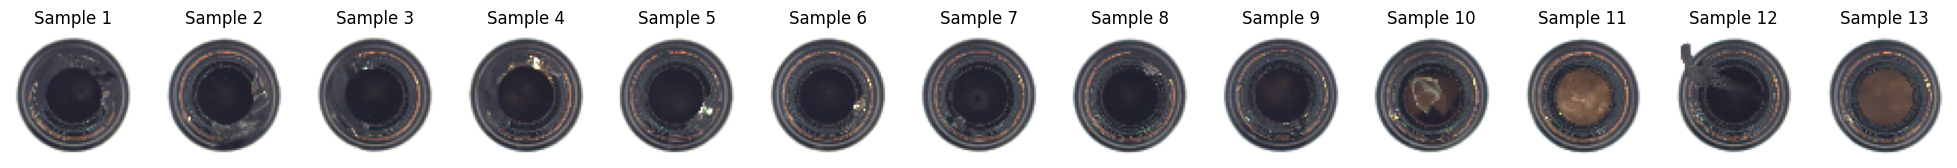

<Figure size 640x480 with 0 Axes>

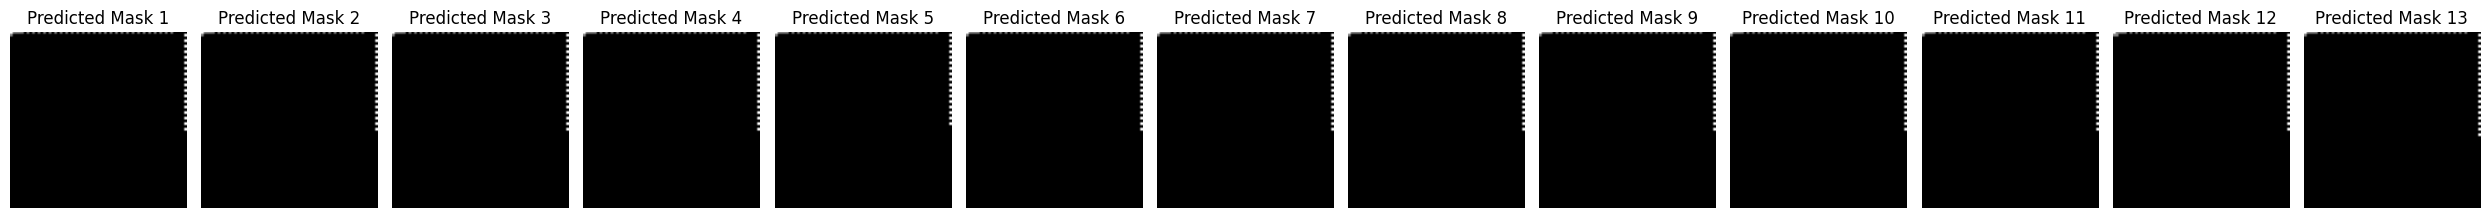

<Figure size 640x480 with 0 Axes>

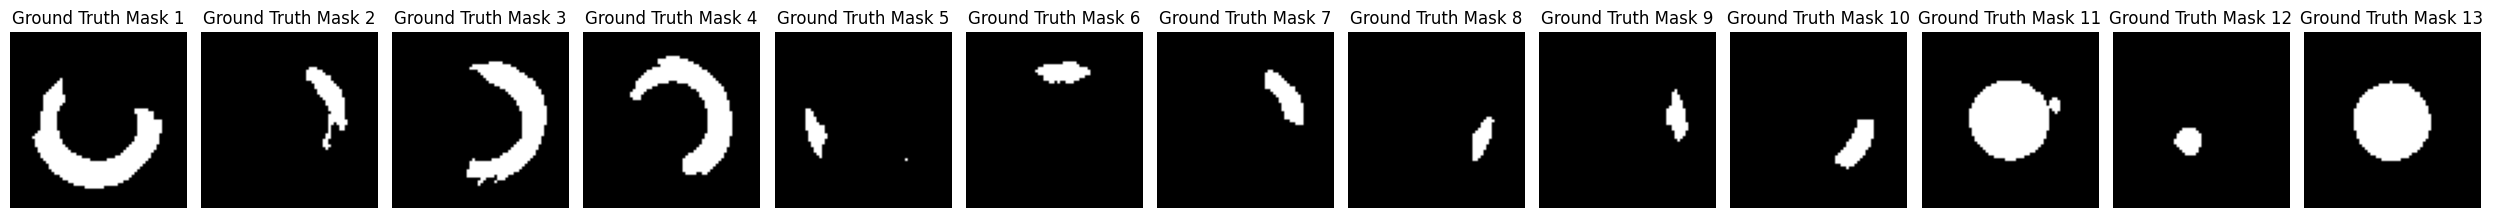

In [40]:
# U-Net Model
class UNET(tf.keras.Model):
    # U-Net 모델 구현 (이전 설명의 코드 활용)
  n_classes=3
  # 학습 데이터와 검증 데이터로 분할
  train_data = (train_image_set, gr_tr_train_set)
  val_data = (test_image_set, gr_tr_test_set)

  # 모델 인스턴스화
  model = UNET(n_classes)

  # 손실 함수 및 최적화 알고리즘 설정
  loss_fn = tf.keras.losses.CategoricalCrossentropy()
  optimizer = tf.keras.optimizers.Adam()

  # 메트릭 설정 (선택 사항)
  metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.MeanIoU(n_classes)]

  # 모델 컴파일
  model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

  # 모델 학습
  epochs = 15
  batch_size = 16
  model.fit(train_data[0], train_data[1], validation_data=(val_data[0], val_data[1]), batch_size=batch_size, epochs=epochs)


  # 모델 평가
  loss, accuracy, mean_iou = model.evaluate(test_image_set, gr_tr_test_set)
  print("Test Loss:", loss)
  print("Test Accuracy:", accuracy)
  print("Test Mean IoU:", mean_iou)


  #########################################################################################################
  # 테스트 세트 예측
  predicted_masks = model.predict(test_image_set)

  # 시각화를 위해 테스트 세트의 이미지 데이터, 예측된 마스크, 실제 마스크를 가져옴
  images = test_image_set
  predicted_masks = np.argmax(predicted_masks, axis=-1)  # 다중 클래스 예측 결과를 클래스 인덱스로 변환
  ground_truth_masks = gr_tr_test_set

  # 테스트 세트의 이미지, 예측된 마스크, 실제 마스크 시각화
  num_samples = images.shape[0]

  plt.figure(figsize=(25, 5))
  for i in range(num_samples):
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(images[i])
      plt.title('Sample {}'.format(i + 1))
      plt.axis('off')
  plt.show()

  # 각 subplot 간의 간격을 조절
  plt.subplots_adjust(wspace=0.5)
  plt.show()

  plt.figure(figsize=(25, 5))
  for i in range(num_samples):
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(predicted_masks[i], cmap='gray')
      plt.title('Predicted Mask {}'.format(i + 1))
      plt.axis('off')
  plt.tight_layout()
  plt.show()

  # 각 subplot 간의 간격을 조절
  plt.subplots_adjust(wspace=0.5)
  plt.show()


  plt.figure(figsize=(25, 5))
  for i in range(num_samples):
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(ground_truth_masks[i], cmap='gray')
      plt.title('Ground Truth Mask {}'.format(i + 1))
      plt.axis('off')
  plt.tight_layout()
  plt.show()


#FastAPI

In [41]:
!pip install fastapi
!pip install uvicorn
!pip install pyngrok
!pip install python-multipart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=cbbe8f1056a7e884b703618326a6213a36b9fdd54b236811f38f6efefe777158
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 1.7 MB/s eta 0:00:00


In [42]:
#FastAPI Library
from typing import Union
from fastapi import FastAPI, UploadFile, File
from tensorflow.keras.models import load_model
from starlette.requests import Request
from fastapi import FastAPI, HTTPException, UploadFile, File
from starlette.requests import Request
from starlette.responses import HTMLResponse
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import io

In [53]:
import io
import numpy as np
from PIL import Image
from fastapi import FastAPI, UploadFile, File, Request

# 이전에 모델을 로드하거나 생성하고 model 변수에 할당했다고 가정합니다.
# 예시로 모델을 아래와 같이 가정하겠습니다.
# 모델은 이미지 크기를 (64, 64, 3)으로 입력으로 받는 것을 가정합니다.
# model = load_model("your_model_path")

app = FastAPI()

# 이전 코드와 동일한 "/predict" 엔드포인트
@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    # 이미지 불러오기 및 전처리
    image = Image.open(io.BytesIO(await file.read()))
    image = image.resize((64, 64)).convert('L')
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # 예측
    pred = model.predict(image)
    result = np.argmax(pred)

    return {"result": int(result)}

# 새로운 엔드포인트를 추가합니다.
@app.post("/predict_with_image")
async def predict_with_image(image: UploadFile = File(...)):
    # 이미지 불러오기 및 전처리
    image = Image.open(io.BytesIO(await image.read()))
    image = image.resize((64, 64)).convert('L')
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # 예측
    pred = model.predict(image)
    result = np.argmax(pred)

    return {"result": int(result)}

@app.get("/", response_class=HTMLResponse)
async def read_root(request: Request):
    return """
    <html>
        <body>
            <form action="/predict" enctype="multipart/form-data" method="post">
                <input name="file" type="file">
                <input type="submit">
            </form>
        </body>
    </html>
    """



ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-7' coro=<Server.serve() done, defined at /usr/local/lib/python3.10/dist-packages/uvicorn/server.py:63> exception=SystemExit(1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/uvicorn/server.py", line 160, in startup
    server = await loop.create_server(
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1505, in create_server
    raise OSError(err.errno, 'error while attempting '
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-9b35ecaa276d>", line 4, in <cell line: 4>
    run(app, host="0.0.0.0", port=8000)
  File "/usr/

In [56]:
# FastAPI 서버 실행
from uvicorn import run

run(app, host="0.0.0.0", port=8001)

INFO:     Started server process [2879]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2879]


In [52]:
!killall uvicorn

uvicorn: no process found
